# Machine Learning Model Implementation For Extreme Gradient Boosting.

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, uniform
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from math import sqrt
import pickle
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Load the data into DataFrame
file_path = 'car_dataset.csv'
df = pd.read_csv(file_path)

In [4]:
# Dropping columns that have no impact on price prediction, "title".
df = df.drop('title', axis=1)

In [5]:
# Understanding the structure of the data (rows, columns)
df.shape

(25100, 9)

In [6]:
# Remove duplicate rows
df = df.drop_duplicates()

In [7]:
# Print the head of the data to see how it looks like
df.head()


,Year,Car Body Type,Mileage,Cylinder Volume,Horsepower,Transmission,Petrol Type,Owners,price
0,2013,Convertible,"82,000 miles",2.0L,208BHP,Auto,Petrol,1 owner,"£9,870"
1,2019,Convertible,"25,436 miles",1.5L,130BHP,Manual,Petrol,1 owner,"£14,250"
2,2012,SUV,"67,114 miles",3.0L,245BHP,Auto,Diesel,5 owners,"£19,450"
3,2013,Coupe,"91,000 miles",2.0L,168BHP,Manual,Diesel,1 owner,"£10,395"
4,2021,Convertible,"13,000 miles",4.0L,711BHP,Auto,Petrol,2 owners,"£199,995"


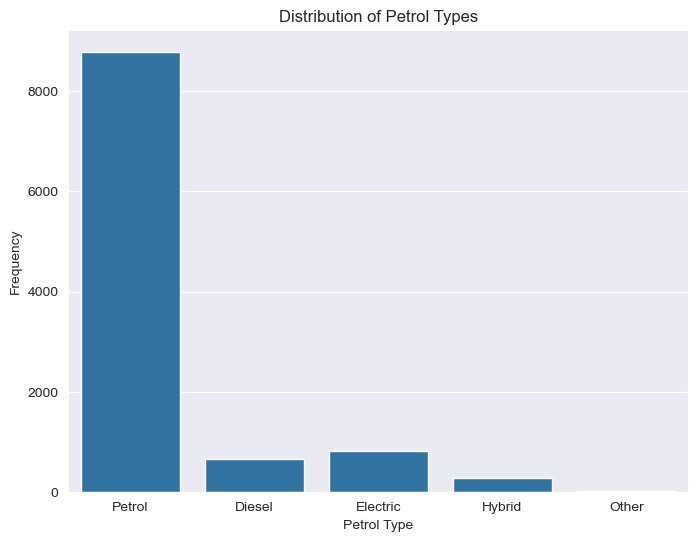

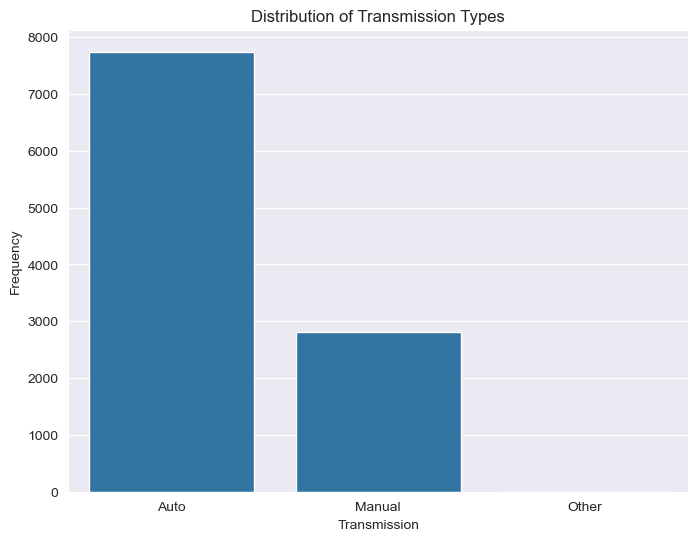

In [8]:
# Plot the distribution of the 'Petrol Type' feature
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Petrol Type')
plt.title("Distribution of Petrol Types")
plt.xlabel("Petrol Type")
plt.ylabel("Frequency")
plt.show()

# Plot the distribution of the 'Transmission' feature
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Transmission')
plt.title("Distribution of Transmission Types")
plt.xlabel("Transmission")
plt.ylabel("Frequency")
plt.show()

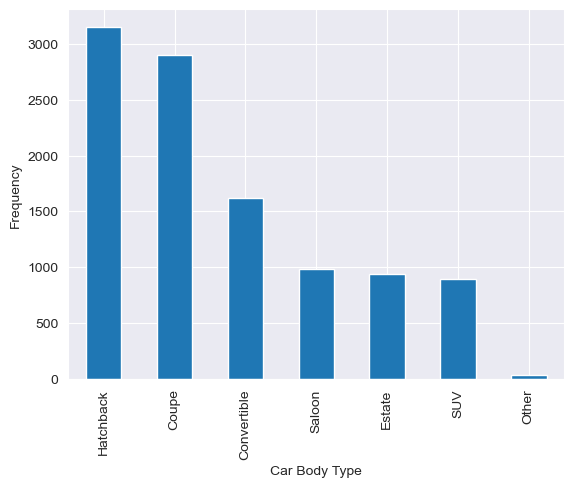

In [9]:
# create a filtered DataFrame with only the "SUV" and "Saloon" categories
filtered_df = df[df["Car Body Type"].isin(["SUV", "Saloon", 'Estate', 'Coupe', 'Other', 'Hatchback', 'Convertible'])]

# create a bar chart of the frequency distribution of the "Car Body Type" feature
filtered_df["Car Body Type"].value_counts().plot(kind="bar")

# set the x-label and y-label for the chart
plt.xlabel("Car Body Type")
plt.ylabel("Frequency")

# show the chart
plt.show()

# Cleaning & Encoding Data

In [10]:
# Removing unwanted strings, such as pound symbol (£) , "owners", "BHP", "L", and "miles".
df["Mileage"] = df["Mileage"].str.replace(",", "").str.replace("miles", "").str.strip()
df["price"] = df["price"].str.replace(",", "").str.replace("£", "").str.strip()
df['Cylinder Volume'] = df['Cylinder Volume'].str.replace('L', '').str.strip()
df['Horsepower'] = df['Horsepower'].str.replace('BHP', '').str.strip()
df['Owners'] = df['Owners'].str.replace('owners', '').str.replace('owner', '').str.strip()

# Convert mileage, Horsepower, Cylinder Volume, owners, and price to numeric.
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')
df['Horsepower'] = pd.to_numeric(df['Horsepower'], errors='coerce')
df['Cylinder Volume'] = pd.to_numeric(df['Cylinder Volume'], errors='coerce')
df['Owners'] = pd.to_numeric(df['Owners'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [11]:
# Label encode the categorical data that is not numeric
label_encoder = LabelEncoder()
df['Transmission'] = label_encoder.fit_transform(df['Transmission'])

# Calculate the mean of the target variable for each category in the 'Petrol Type' feature
mean_encoding = df.groupby('Petrol Type')['price'].mean()
mean_encoding_body_type = df.groupby('Car Body Type')['price'].mean()

# Map the mean encoding to the 'Petrol Type' feature to create a new encoded feature
df['Petrol_Type_Encoded'] = df['Petrol Type'].map(mean_encoding)

# Map the mean encoding to the 'Car Body Type' feature to create a new encoded feature
df['Car_Body_Type_Encoded'] = df['Car Body Type'].map(mean_encoding_body_type)

# Round the encoded variables to 4 decimal places
df['Petrol_Type_Encoded'] = df['Petrol_Type_Encoded'].round(4)
df['Car_Body_Type_Encoded'] = df['Car_Body_Type_Encoded'].round(4)

# Drop the original "Car Body Type" and "Petrol Type" columns
df = df.drop(columns=['Car Body Type', 'Petrol Type'])

In [12]:
# Ensuring data type are numerical to fit the model
df.dtypes

Year                       int64
Mileage                  float64
Cylinder Volume          float64
Horsepower               float64
Transmission               int32
Owners                   float64
price                    float64
Petrol_Type_Encoded      float64
Car_Body_Type_Encoded    float64
dtype: object

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10569 entries, 0 to 25099
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   10569 non-null  int64  
 1   Mileage                10511 non-null  float64
 2   Cylinder Volume        9718 non-null   float64
 3   Horsepower             9833 non-null   float64
 4   Transmission           10569 non-null  int32  
 5   Owners                 8906 non-null   float64
 6   price                  10460 non-null  float64
 7   Petrol_Type_Encoded    10566 non-null  float64
 8   Car_Body_Type_Encoded  10565 non-null  float64
dtypes: float64(7), int32(1), int64(1)
memory usage: 784.4 KB


In [14]:
# Calculate the median of the numerical attributes
median_values = df.median()

# Print the median values in a table
print("Median values:")
print(median_values.to_frame())

Median values:
                                0
Year                    2018.0000
Mileage                26000.0000
Cylinder Volume            3.0000
Horsepower               345.0000
Transmission               0.0000
Owners                     2.0000
price                  36990.0000
Petrol_Type_Encoded    64011.4568
Car_Body_Type_Encoded  72195.6589


# Handling Missing Values

In [15]:
# Handling missing data

df['Cylinder Volume'] = df['Cylinder Volume'].fillna(df['Cylinder Volume'].median())
df['Horsepower'] = df['Horsepower'].fillna(df['Horsepower'].mean())
df['Transmission'] = df['Transmission'].fillna(df['Transmission'].mode())
df['Owners'] = df['Owners'].fillna(df['Owners'].median())

# Replace "POA" (price on application) values with NaN
df['price'] = df['price'].replace('POA', np.nan)

# calculate the median of the existing numerical values in the price column
price_median = df['price'].median()

# replace NaN values with the calculated median
df['price'] = df['price'].fillna(price_median)

# Impute missing or infinite values in 'Mileage' column
mileage_median = df['Mileage'].replace([np.inf, -np.inf], np.nan).dropna().median()
df['Mileage'] = df['Mileage'].replace([np.inf, -np.inf, np.nan], mileage_median)

# Calculate the mode for the 'Petrol_Type_Encoded' column
petrol_type_mode = df['Petrol_Type_Encoded'].mode()[0]
df['Petrol_Type_Encoded'].fillna(petrol_type_mode, inplace=True)

# Calculate the mode for the 'Car_Body_Type' column
car_body_type_mode = df['Car_Body_Type_Encoded'].mode()[0]
df['Car_Body_Type_Encoded'].fillna(car_body_type_mode, inplace=True)

# Impute missing or infinite values in 'price' column
price_median = df['price'].replace([np.inf, -np.inf], np.nan).dropna().median()
df['price'] = df['price'].replace([np.inf, -np.inf, np.nan], price_median)

In [16]:
df.describe()

,Year,Mileage,Cylinder Volume,Horsepower,Transmission,Owners,price,Petrol_Type_Encoded,Car_Body_Type_Encoded
count,10569.000000,10569.000000,10569.000000,10569.000000,10569.000000,10569.000000,1.056900e+04,10569.000000,10569.000000
mean,2015.417542,33054.158861,3.094153,370.186108,0.271643,2.408837,6.117793e+04,61443.962951,61516.276051
std,8.120161,28044.867842,1.304039,145.013343,0.458859,1.598175,7.988409e+04,9788.974452,20964.867804
min,1929.000000,0.000000,0.000000,20.000000,0.000000,1.000000,1.495000e+03,27220.074600,17995.000000
25%,2014.000000,11400.000000,2.000000,256.000000,0.000000,1.000000,2.249900e+04,64011.456800,30736.393200
50%,2018.000000,26000.000000,3.000000,357.000000,0.000000,2.000000,3.699000e+04,64011.456800,72195.658900
75%,2020.000000,47450.000000,4.000000,469.000000,1.000000,3.000000,6.995000e+04,64011.456800,81492.718500
max,2023.000000,222221.000000,34.000000,1184.000000,3.000000,19.000000,1.750000e+06,82089.712200,195000.000000


In [17]:
# Calculate the median of the numerical attributes
median_values = df.median()

# Print the median values in a table
print("Median values:")
print(median_values.to_frame())

Median values:
                                0
Year                    2018.0000
Mileage                26000.0000
Cylinder Volume            3.0000
Horsepower               357.0000
Transmission               0.0000
Owners                     2.0000
price                  36990.0000
Petrol_Type_Encoded    64011.4568
Car_Body_Type_Encoded  72195.6589


### Checking for missing values

In [18]:
# check for any missing values.
print(df.isnull().sum())

Year                     0
Mileage                  0
Cylinder Volume          0
Horsepower               0
Transmission             0
Owners                   0
price                    0
Petrol_Type_Encoded      0
Car_Body_Type_Encoded    0
dtype: int64


In [19]:
# Define the permissible range for the 'Year' column
min_year = 1950
max_year = datetime.datetime.now().year

# Define the permissible range for the 'Cylinder Volume' column
min_cylinder_volume = 20

# Define the permissible range for the 'Owners' column
min_owners = 0
max_owners = 11

# Filter out rows with impermissible values
df = df.query(f"Year >= {min_year} & Year <= {max_year} & `Cylinder Volume` < {min_cylinder_volume} & Owners >= {min_owners} & Owners <= {max_owners}")

df.describe()

,Year,Mileage,Cylinder Volume,Horsepower,Transmission,Owners,price,Petrol_Type_Encoded,Car_Body_Type_Encoded
count,10553.000000,10553.000000,10553.000000,10553.000000,10553.000000,10553.000000,1.055300e+04,10553.000000,10553.000000
mean,2015.464039,32978.900502,3.091140,370.327287,0.270823,2.396664,6.121528e+04,61440.070229,61516.788106
std,7.968336,27948.347073,1.269116,145.022059,0.458471,1.558426,7.992815e+04,9795.882204,20967.770653
min,1953.000000,0.000000,0.000000,50.000000,0.000000,1.000000,1.495000e+03,27220.074600,17995.000000
25%,2014.000000,11382.000000,2.000000,257.000000,0.000000,1.000000,2.250000e+04,64011.456800,30736.393200
50%,2018.000000,26000.000000,3.000000,357.000000,0.000000,2.000000,3.699000e+04,64011.456800,72195.658900
75%,2020.000000,47300.000000,4.000000,469.000000,1.000000,3.000000,6.995000e+04,64011.456800,81492.718500
max,2023.000000,222221.000000,8.000000,1184.000000,3.000000,11.000000,1.750000e+06,82089.712200,195000.000000


# Data Visualisation

### In this block I create a historgram and print the skewness value for each numerical attribute to visualise its distribution. This allows to check if log transormation is required or not to normalise the distribution of data. The price variable is plotted as well only to see its skew value which helped determine the imputation method for the price variable.

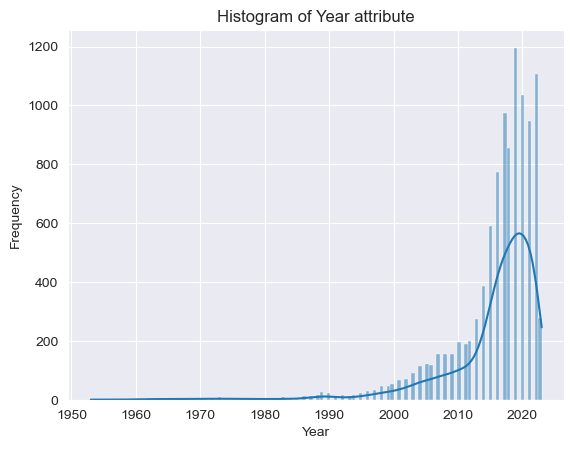

Skewness of the Year attribute: -2.93


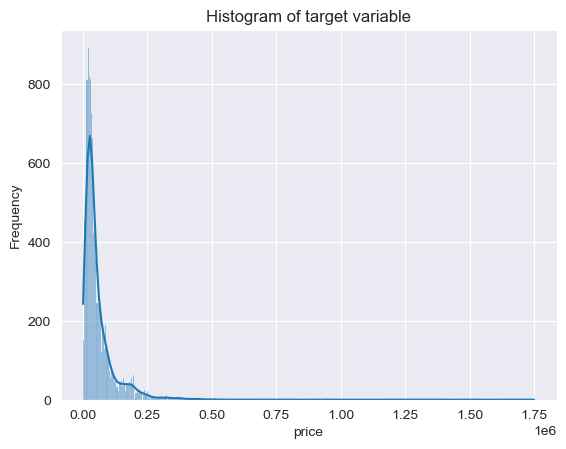

Skewness of the target variable: 6.64


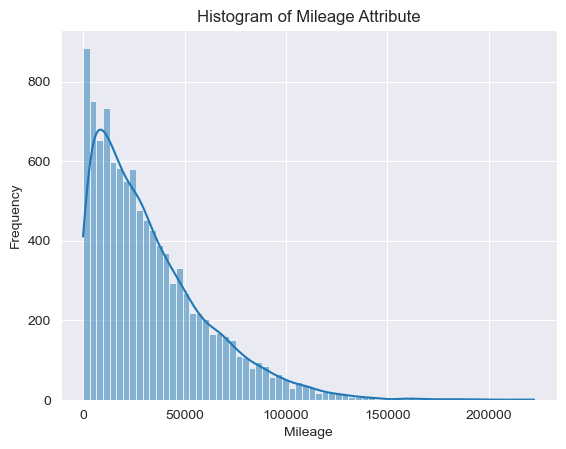

Skewness of the mileage attribute: 1.29


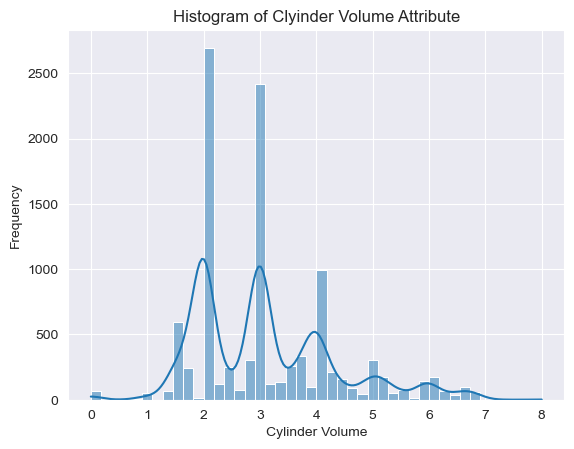

Skewness of the Cylinder Volume attribute: 0.83


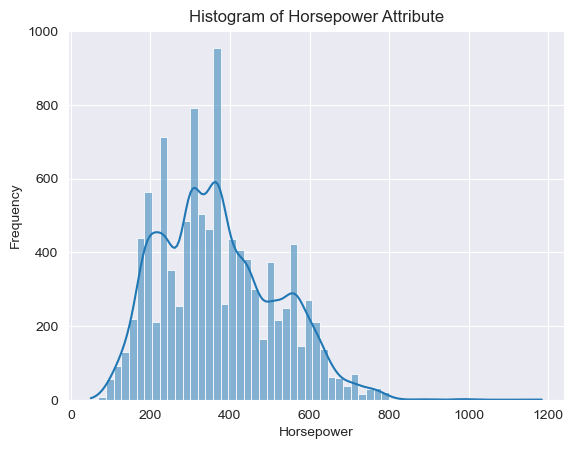

Skewness of the Horsepower attribute: 0.48


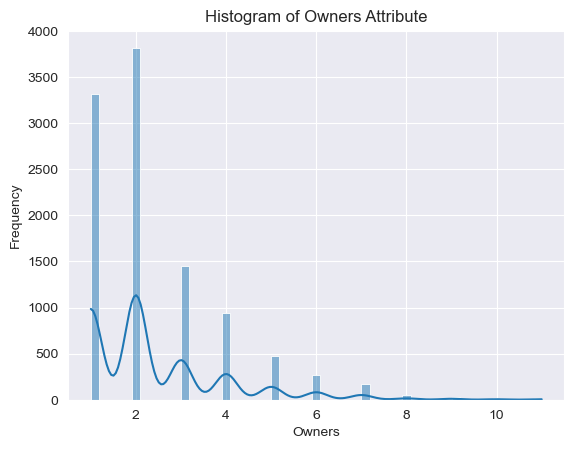

Skewness of the Owners attribute: 1.74


In [20]:
# Create a histogram for the Year attribute
sns.histplot(df['Year'], kde=True)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Histogram of Year attribute')
plt.show()

# Calculate the skewness and print it out
skewness3 = df['Year'].skew()
print(f"Skewness of the Year attribute: {skewness3:.2f}")

sns.histplot(df['price'], kde=True)
plt.xlabel('price')
plt.ylabel('Frequency')
plt.title('Histogram of target variable')
plt.show()

skewness3 = df['price'].skew()
print(f"Skewness of the target variable: {skewness3:.2f}")

sns.histplot(df['Mileage'], kde=True)
plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.title('Histogram of Mileage Attribute')
plt.show()

skewness = df['Mileage'].skew()
print(f"Skewness of the mileage attribute: {skewness:.2f}")

sns.histplot(df['Cylinder Volume'], kde=True)
plt.xlabel('Cylinder Volume')
plt.ylabel('Frequency')
plt.title('Histogram of Clyinder Volume Attribute')
plt.show()

skewness2 = df['Cylinder Volume'].skew()
print(f"Skewness of the Cylinder Volume attribute: {skewness2:.2f}")

sns.histplot(df['Horsepower'], kde=True)
plt.xlabel('Horsepower')
plt.ylabel('Frequency')
plt.title('Histogram of Horsepower Attribute')
plt.show()

skewness3 = df['Horsepower'].skew()
print(f"Skewness of the Horsepower attribute: {skewness3:.2f}")


sns.histplot(df['Owners'], kde=True)
plt.xlabel('Owners')
plt.ylabel('Frequency')
plt.title('Histogram of Owners Attribute')
plt.show()

skewness3 = df['Owners'].skew()
print(f"Skewness of the Owners attribute: {skewness3:.2f}")

### Below are boxplots for the encoded categorical features to access if they require log transformation.

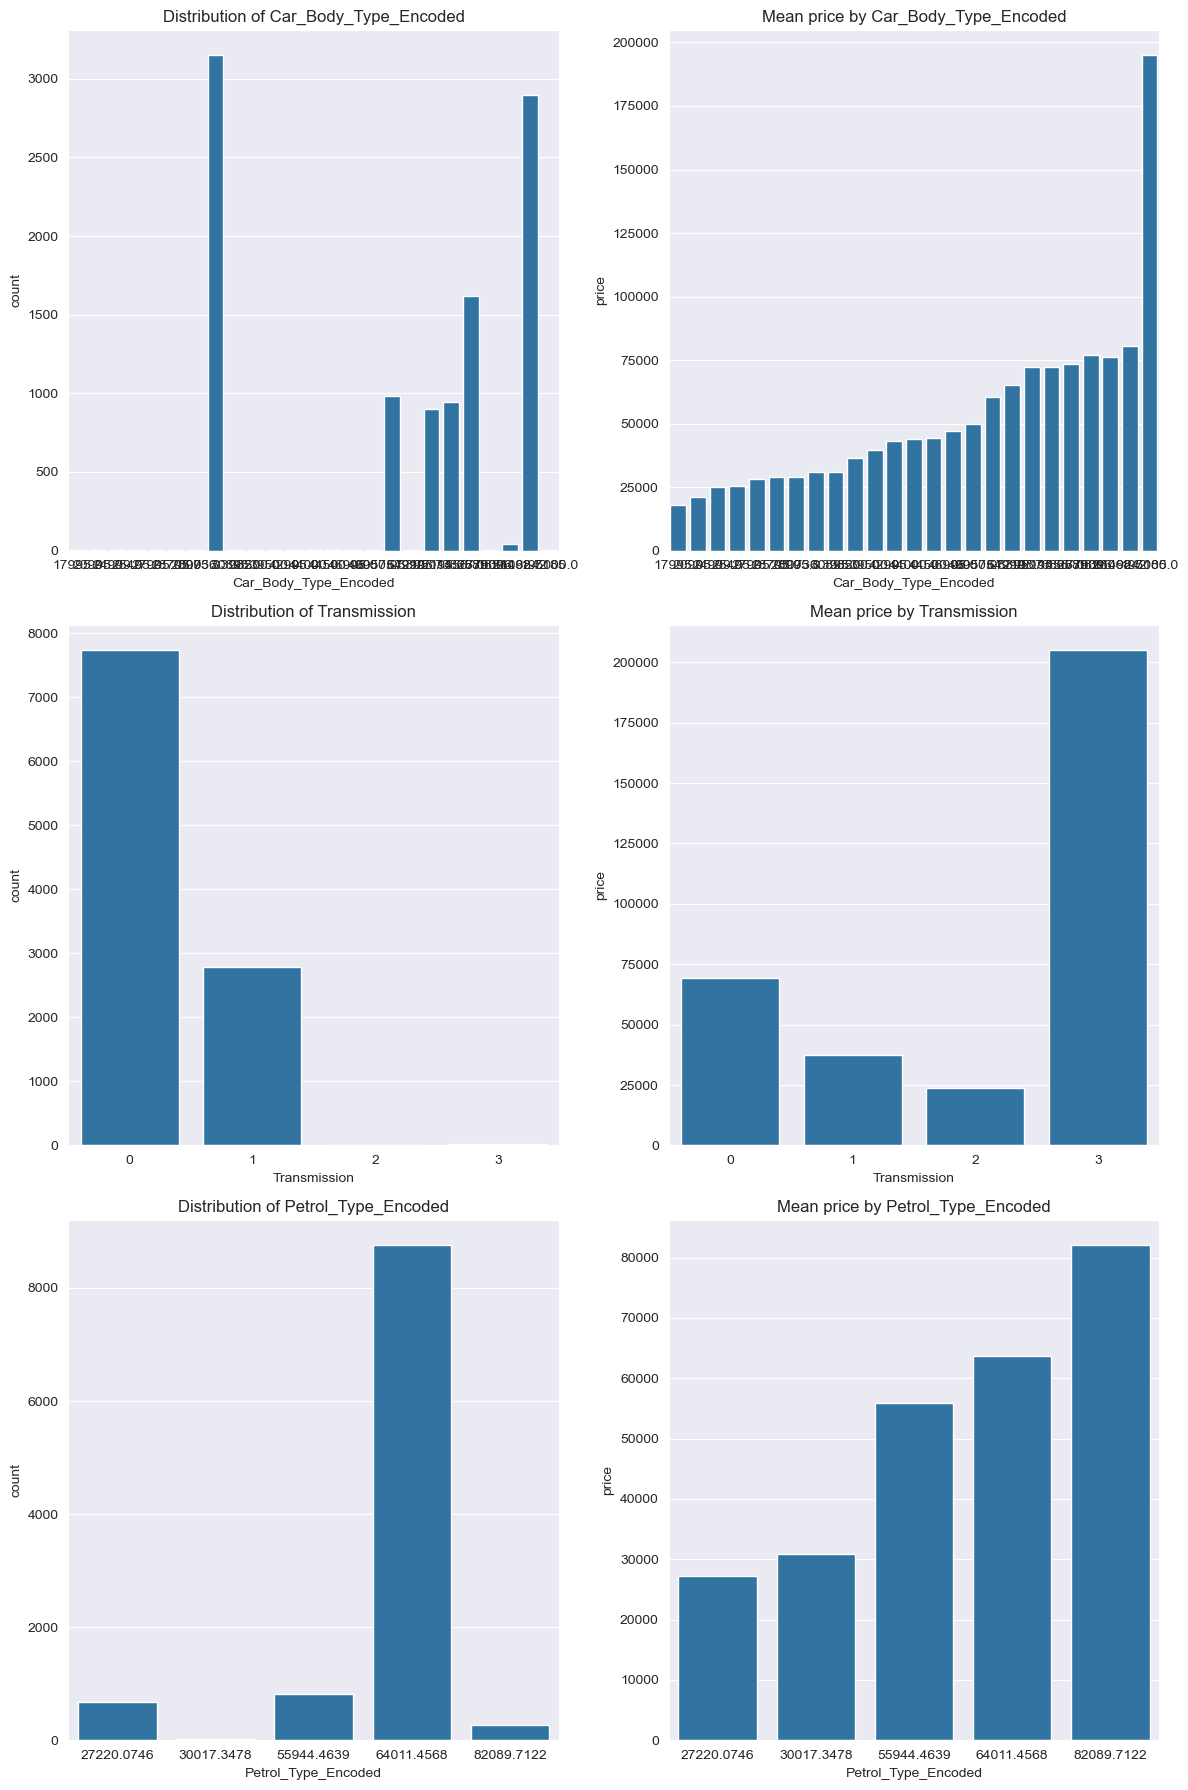

In [21]:
# Visualising the distribution of data for the categorical features.
# The categorical features are Car Body Type, Transmission, and Petrol Type.
categorical_variables = ['Car_Body_Type_Encoded', 'Transmission', 'Petrol_Type_Encoded']
target_variable = 'price'

fig, axes = plt.subplots(len(categorical_variables), 2, figsize=(12, 6 * len(categorical_variables)))

for idx, attribute in enumerate(categorical_variables):
    # Bar plot showing the distribution of categories
    ax1 = axes[idx, 0]
    sns.countplot(data=df, x=attribute, ax=ax1)
    ax1.set_title(f"Distribution of {attribute}")

    # Bar plot showing the mean price for each category
    ax2 = axes[idx, 1]
    sns.barplot(data=df, x=attribute, y=target_variable, estimator=np.mean, ci=None, ax=ax2)
    ax2.set_title(f"Mean {target_variable} by {attribute}")

plt.tight_layout()
plt.show()

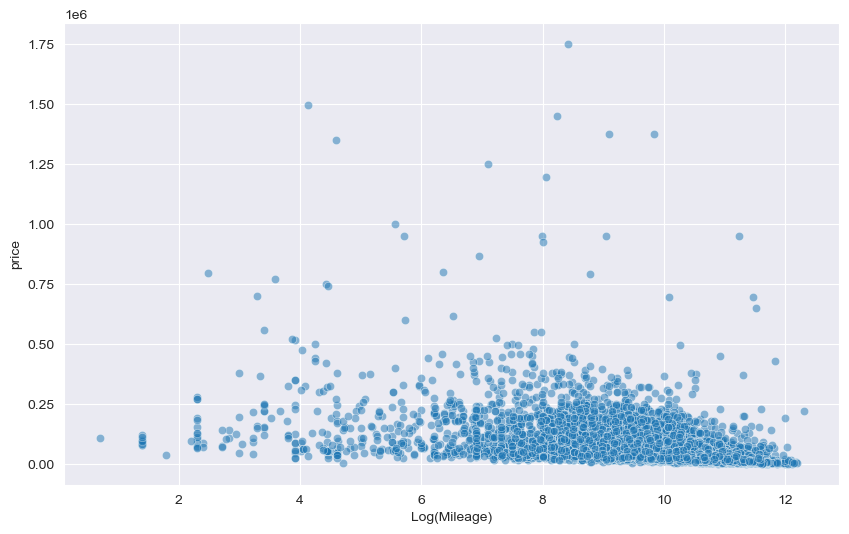

In [22]:
# Apply logarithmic transformation to the Mileage column
df['log_Mileage'] = np.log(df['Mileage'])

# Create a scatter plot for 'log_Mileage' vs 'price'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_Mileage', y='price', data=df, alpha=0.5)

# Add xlabel and ylabel
plt.xlabel("Log(Mileage)")
plt.ylabel("price")

# Show the plot
plt.show()

df = df.drop(columns=['log_Mileage'])

### Here I plot the numerical features against the target variable along with the correlation.

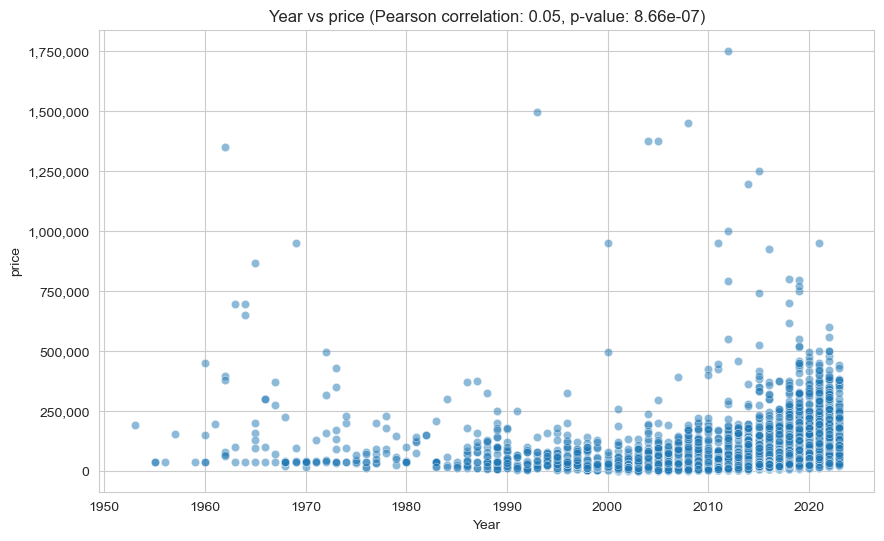

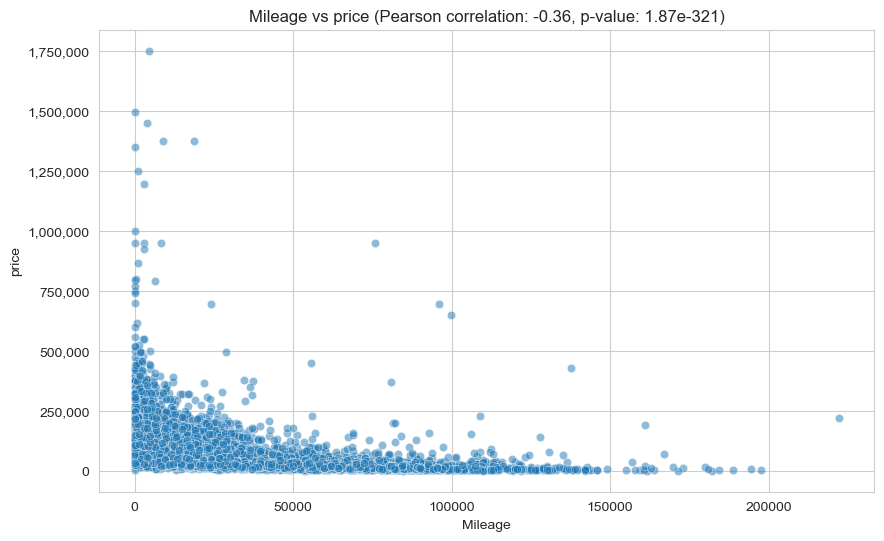

In [23]:
# Visualising the features with against th target variable, 'price'

# Setting the white grid
sns.set_style("whitegrid")

# Custom y-axis tick format to show the full price scale rathert than scientific notation.
def custom_formatter(x, _):
    return f'{x:,.0f}'

# Create a scatter plot for 'Year' vs 'price'
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='Year', y='price', data=df, alpha=0.5)
ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

# Calculate Pearson correlation coefficient and p-value then add it to the plot
corr_coeff, p_value = pearsonr(df['Year'], df['price'])
plt.title(f"Year vs price (Pearson correlation: {corr_coeff:.2f}, p-value: {p_value:.2e})")
plt.xlabel("Year")
plt.ylabel("price")
plt.show()

# Create a scatter plot for 'Mileage' vs 'price' 
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='Mileage', y='price', data=df, alpha=0.5)
ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

# Calculate Pearson correlation coefficient and p-value then add it to the plot
corr_coeff, p_value = pearsonr(df['Mileage'], df['price'])
plt.title(f"Mileage vs price (Pearson correlation: {corr_coeff:.2f}, p-value: {p_value:.2e})")
plt.xlabel("Mileage")
plt.ylabel("price")
plt.show()


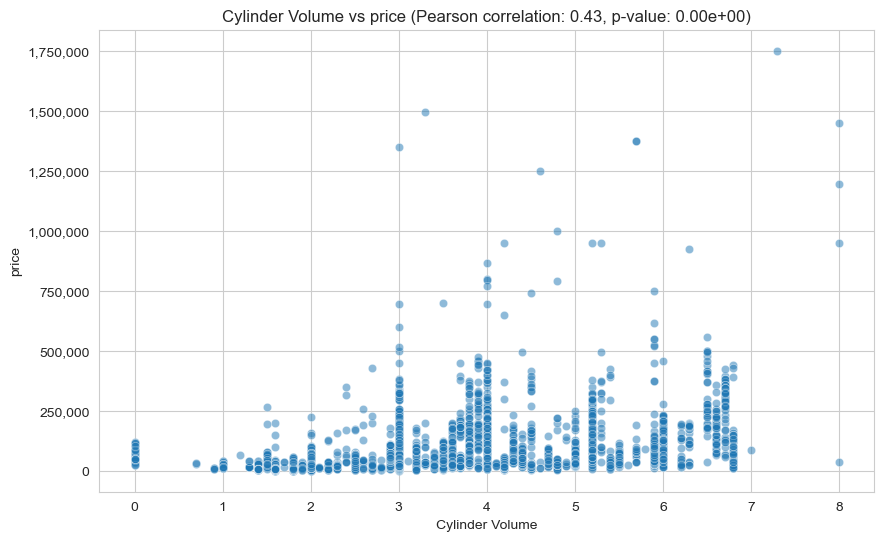

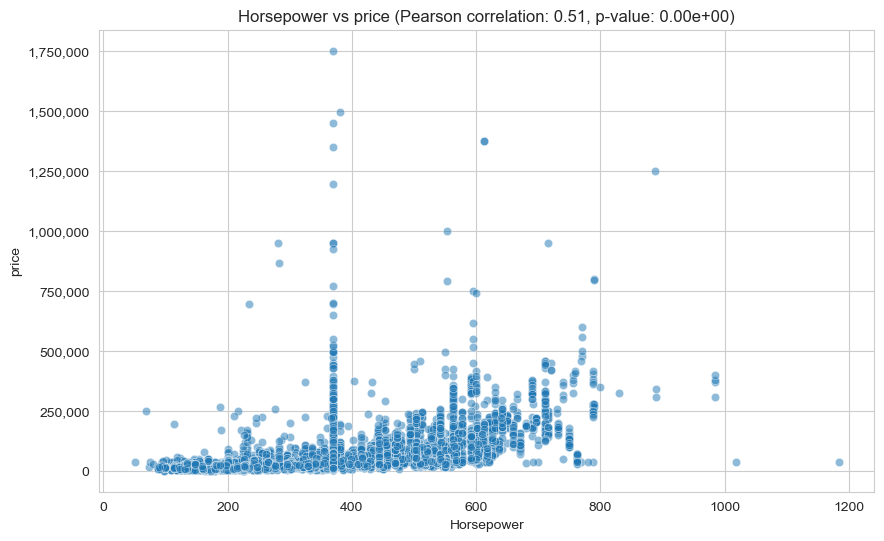

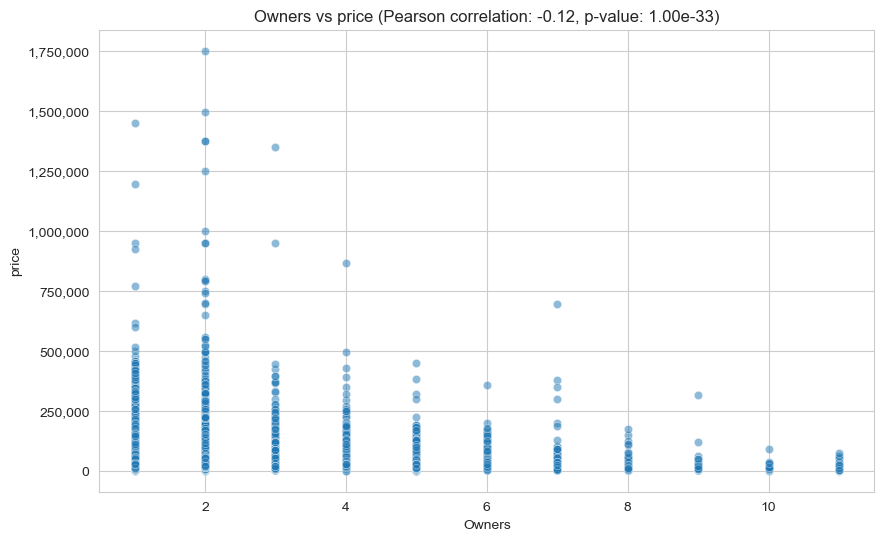

In [24]:
# Create a scatter plot for 'Cylinder Volume' vs 'price'
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='Cylinder Volume', y='price', data=df, alpha=0.5)
ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

# Calculate Pearson correlation coefficient and p-value then add it to the plot
corr_coeff, p_value = pearsonr(df['Cylinder Volume'], df['price'])
plt.title(f"Cylinder Volume vs price (Pearson correlation: {corr_coeff:.2f}, p-value: {p_value:.2e})")
plt.xlabel("Cylinder Volume")
plt.ylabel("price")
plt.show()

# Create a scatter plot for 'Horsepower' vs 'price'
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='Horsepower', y='price', data=df, alpha=0.5)
ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

# Calculate Pearson correlation coefficient and p-value
corr_coeff, p_value = pearsonr(df['Horsepower'], df['price'])

# Add Pearson correlation coefficient and p-value to the plot title
plt.title(f"Horsepower vs price (Pearson correlation: {corr_coeff:.2f}, p-value: {p_value:.2e})")
plt.xlabel("Horsepower")
plt.ylabel("price")
plt.show()


# Create a scatter plot for 'Horsepower' vs 'price'
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='Owners', y='price', data=df, alpha=0.5)
ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

# Calculate Pearson correlation coefficient and p-value
corr_coeff, p_value = pearsonr(df['Owners'], df['price'])

# Add Pearson correlation coefficient and p-value to the plot title
plt.title(f"Owners vs price (Pearson correlation: {corr_coeff:.2f}, p-value: {p_value:.2e})")
plt.xlabel("Owners")
plt.ylabel("price")
plt.show()


### Here I plot the One-hot encoded features against the target variable, along with the correlation. In this case it is only Transmission.

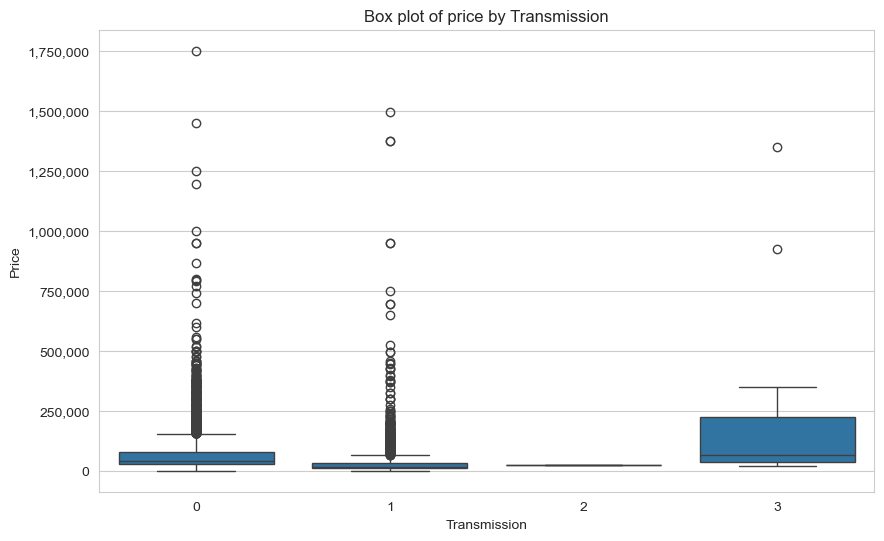

In [25]:
# In this block I visualise the Transmission against the target
# variable to see if there are any correlations

# Create a custom y-axis formatter
def y_formatter(x, pos):
    return '{:,.0f}'.format(x)

# Create a box plot for 'Transmission' vs 'price'
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Transmission', y='price', data=df)

# Set the y-axis formatter
ax.yaxis.set_major_formatter(FuncFormatter(y_formatter))

plt.title("Box plot of price by Transmission")
plt.xlabel("Transmission")
plt.ylabel("Price")
plt.show()

### Here I plot the Target Encoded features against the target variable along with the correlation.

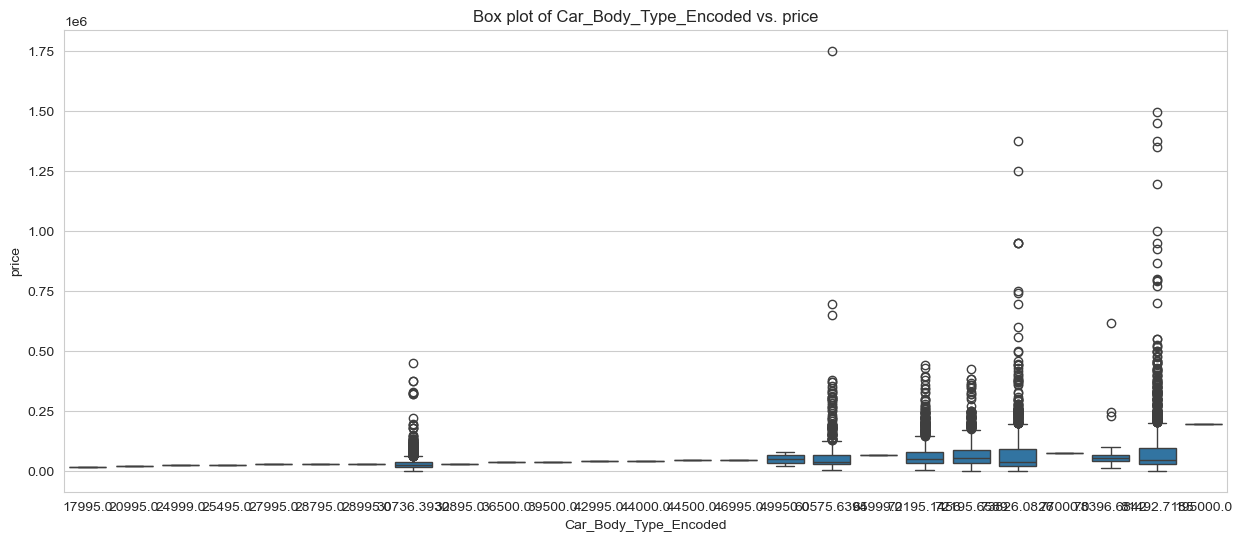

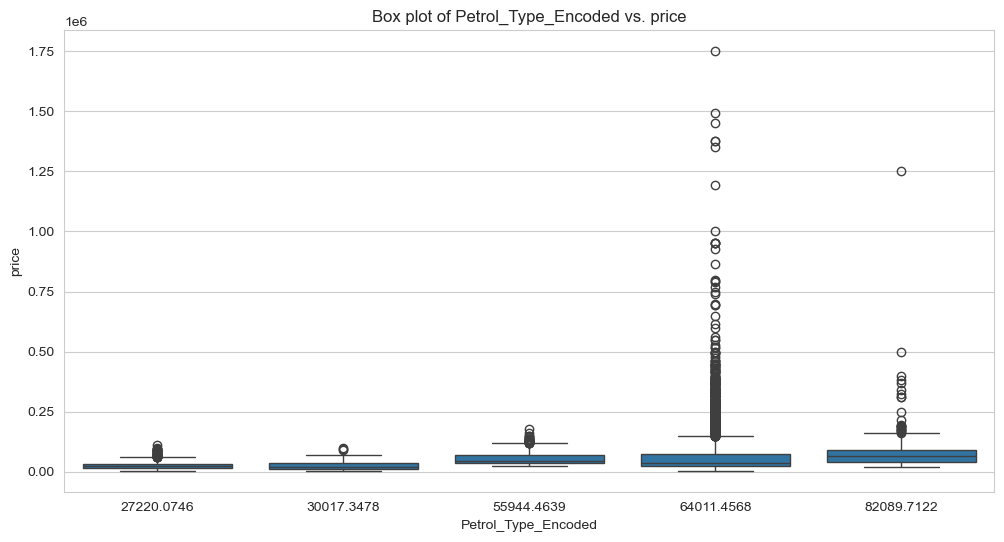

Transmission            -0.148359
Car_Body_Type_Encoded    0.258578
Petrol_Type_Encoded      0.121691
Name: price, dtype: float64


In [29]:
# Visualising the Target Enocded Variables, Car Body Type and Petrol Type.

# Visualize Car_Body_Type_Encoded
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='Car_Body_Type_Encoded', y='price')
plt.title('Box plot of Car_Body_Type_Encoded vs. price')
plt.show()

# Visualize Petrol_Type_Encoded
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Petrol_Type_Encoded', y='price')
plt.title('Box plot of Petrol_Type_Encoded vs. price')
plt.show()

correlations = df[['Transmission', 'Car_Body_Type_Encoded', 'Petrol_Type_Encoded', 'price']].corr()
price_correlations = correlations['price'].drop('price')
print(price_correlations)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10553 entries, 0 to 25099
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   10553 non-null  int64  
 1   Mileage                10553 non-null  float64
 2   Cylinder Volume        10553 non-null  float64
 3   Horsepower             10553 non-null  float64
 4   Transmission           10553 non-null  int32  
 5   Owners                 10553 non-null  float64
 6   price                  10553 non-null  float64
 7   Petrol_Type_Encoded    10553 non-null  float64
 8   Car_Body_Type_Encoded  10553 non-null  float64
dtypes: float64(7), int32(1), int64(1)
memory usage: 783.2 KB


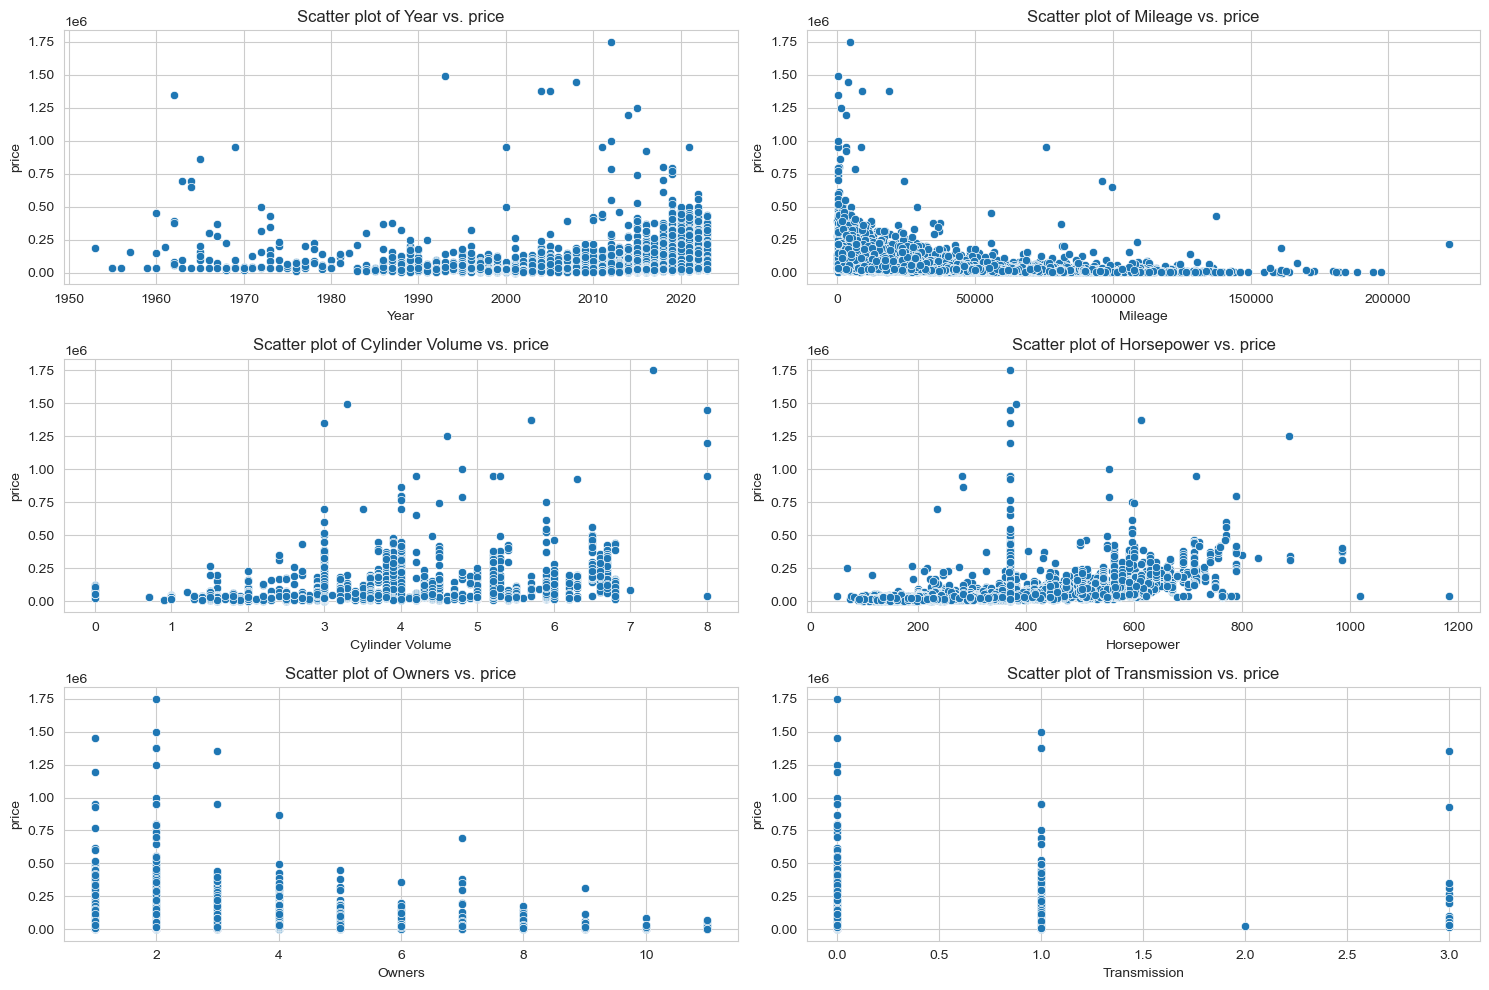

Year               0.047870
Mileage           -0.360553
Cylinder Volume    0.426043
Horsepower         0.511920
Owners            -0.117436
Transmission      -0.148359
Name: price, dtype: float64


In [31]:
attributes = ['Year', 'Mileage', 'Cylinder Volume', 'Horsepower', 'Owners', 'Transmission']

# Create a figure and a 2x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# Loop through the list of attributes and generate scatter plots
for idx, attribute in enumerate(attributes):
    row, col = idx // 2, idx % 2
    sns.scatterplot(data=df, x=attribute, y='price', ax=axes[row, col])
    axes[row, col].set_title(f'Scatter plot of {attribute} vs. price')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Calculate and print the correlation values
correlations = df[['Year', 'Mileage', 'Cylinder Volume', 'Horsepower', 'Owners', 'Transmission','price']].corr()
price_correlations = correlations['price'].drop('price')
print(price_correlations)

In [32]:
# In this block I create new features and plot them against the price variable

# Creating an Age of the car feature
current_year = datetime.datetime.now().year
df['Age'] = current_year - df['Year']

# "Mileage" and "Age", since they are both negatively correlated.
df['Mileage_Age'] = df['Mileage'] * df['Age']

# Feature for Mileage and Owners since both are negatively related
df['Mileage_Owners'] = df['Mileage'] * df['Owners']

# Horsepower and Clyinder Volume, since they are both postively related with the price.
df['HP_Cyln_Volume'] = df['Horsepower'] * df['Cylinder Volume']

# Horsepower and Clyinder Volume Ratio Percentage, since they are both postively related with the price.
df['HP_Cyln_Volume_Percent'] = df['Horsepower'] / df['Cylinder Volume']

# Cylinder Volume Ratio.
df['Cyln_Ratio'] = (df['Cylinder Volume'] - df['Cylinder Volume'].min()) / (df['Cylinder Volume'].max() - df['Cylinder Volume'].min())

# Mileage Ratio 
df['Mileage_Ratio'] = (df['Mileage'] - df['Mileage'].min()) / (df['Mileage'].max() - df['Mileage'].min())

# Round the encoded variables to 4 decimal places
df['Cyln_Ratio'] = df['Cyln_Ratio'].round(4)
df['Mileage_Ratio'] = df['Mileage_Ratio'].round(4)
df['HP_Cyln_Volume_Percent'] = df['HP_Cyln_Volume_Percent'].round(4)

# Removing miussing values from the new features created.
df['Cyln_Ratio'] = df['Cyln_Ratio'].replace([np.inf, -np.inf], np.nan)
df['Cyln_Ratio'] = df['Cyln_Ratio'].fillna(df['Cyln_Ratio'].median())

# Removing miussing values from the new features created.
df['HP_Cyln_Volume_Percent'] = df['HP_Cyln_Volume_Percent'].replace([np.inf, -np.inf], np.nan)
df['HP_Cyln_Volume_Percent'] = df['HP_Cyln_Volume_Percent'].fillna(df['HP_Cyln_Volume_Percent'].mean())

# Dropping the original columns
df = df.drop(columns=['Age'])
df = df.drop(columns=['Year'])
df = df.drop(columns=['Owners'])

In [638]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10553 entries, 0 to 25099
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Mileage                 10553 non-null  float64
 1   Cylinder Volume         10553 non-null  float64
 2   Horsepower              10553 non-null  float64
 3   Transmission            10553 non-null  int32  
 4   price                   10553 non-null  float64
 5   Petrol_Type_Encoded     10553 non-null  float64
 6   Car_Body_Type_Encoded   10553 non-null  float64
 7   Mileage_Age             10553 non-null  float64
 8   Mileage_Owners          10553 non-null  float64
 9   HP_Cyln_Volume          10553 non-null  float64
 10  HP_Cyln_Volume_Percent  10553 non-null  float64
 11  Cyln_Ratio              10553 non-null  float64
 12  Mileage_Ratio           10553 non-null  float64
dtypes: float64(12), int32(1)
memory usage: 1.1 MB


In [33]:
# Check if the new feautres are created
print(df.columns)

Index(['Mileage', 'Cylinder Volume', 'Horsepower', 'Transmission', 'price',
       'Petrol_Type_Encoded', 'Car_Body_Type_Encoded', 'Mileage_Age',
       'Mileage_Owners', 'HP_Cyln_Volume', 'HP_Cyln_Volume_Percent',
       'Cyln_Ratio', 'Mileage_Ratio'],
      dtype='object')


## Correlation Analysis for new features

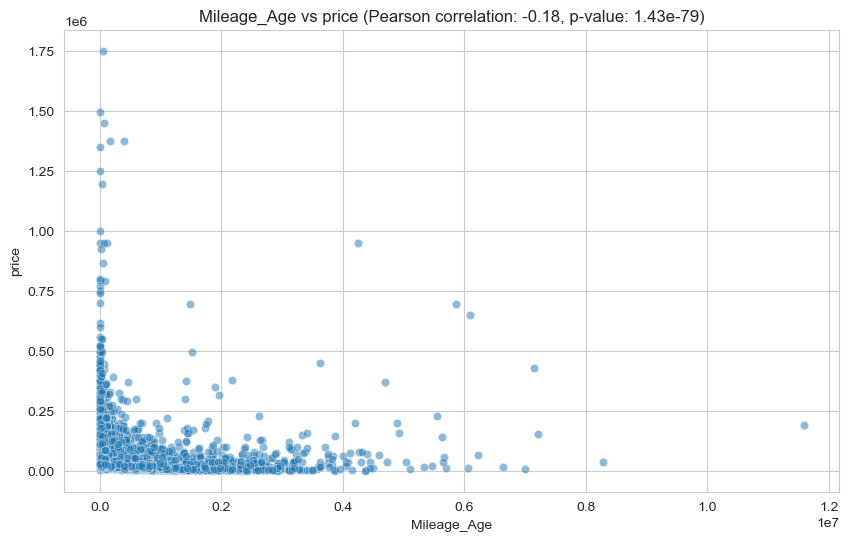

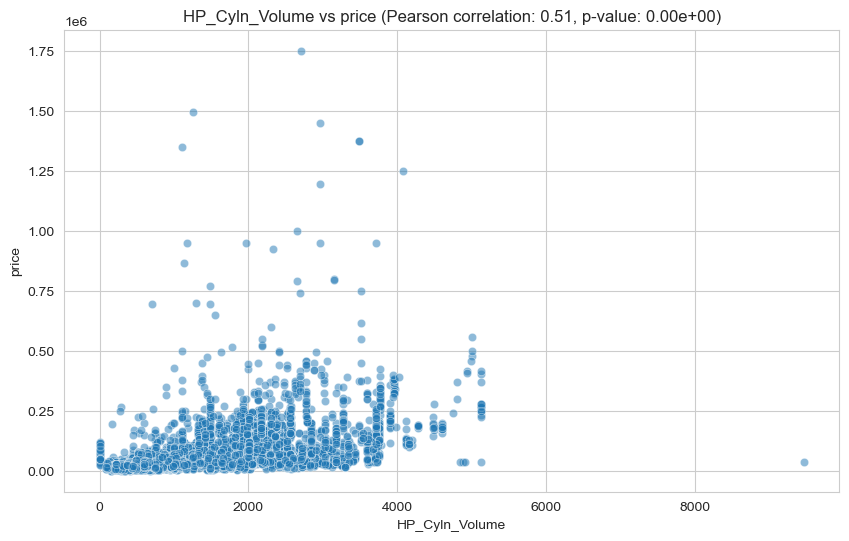

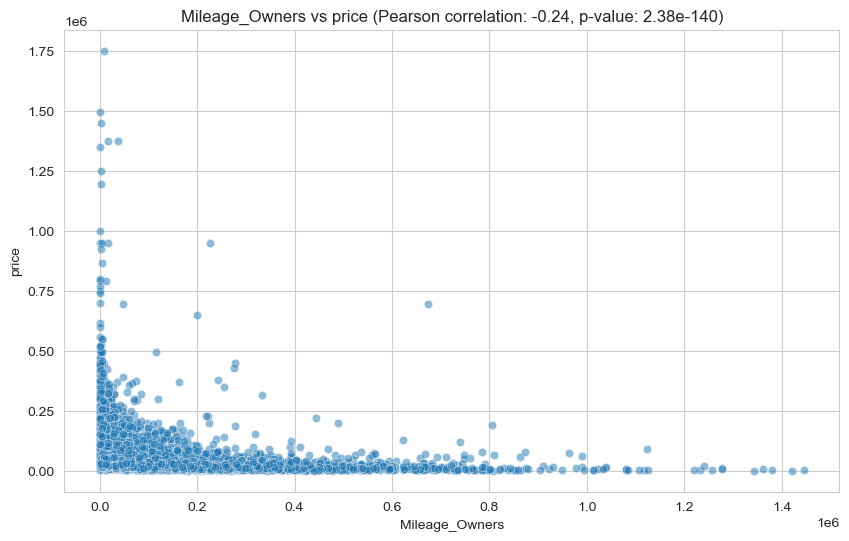

In [34]:
# Create a scatter plot for 'Mileage_Age' versus 'price'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Mileage_Age', y='price', data=df, alpha=0.5)

# Calculate Pearson correlation coefficient and p-value and add it to the plot title
corr_coeff, p_value = pearsonr(df['Mileage_Age'], df['price'])
plt.title(f"Mileage_Age vs price (Pearson correlation: {corr_coeff:.2f}, p-value: {p_value:.2e})")
plt.xlabel("Mileage_Age")
plt.ylabel("price")
plt.show()

# Create a scatter plot for 'HP_Clyn_Volume'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='HP_Cyln_Volume', y='price', data=df, alpha=0.5)

# Calculate Pearson correlation coefficient and p-value and add it to the plot title
corr_coeff, p_value = pearsonr(df['HP_Cyln_Volume'], df['price'])
plt.title(f"HP_Cyln_Volume vs price (Pearson correlation: {corr_coeff:.2f}, p-value: {p_value:.2e})")
plt.xlabel("HP_Cyln_Volume")
plt.ylabel("price")
plt.show()

# Create a scatter plot for 'Mileage_Owners' versus 'price'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Mileage_Owners', y='price', data=df, alpha=0.5)

# Calculate Pearson correlation coefficient and p-value add it to the plot title
corr_coeff, p_value = pearsonr(df['Mileage_Owners'], df['price'])
plt.title(f"Mileage_Owners vs price (Pearson correlation: {corr_coeff:.2f}, p-value: {p_value:.2e})")
plt.xlabel("Mileage_Owners")
plt.ylabel("price")
plt.show()

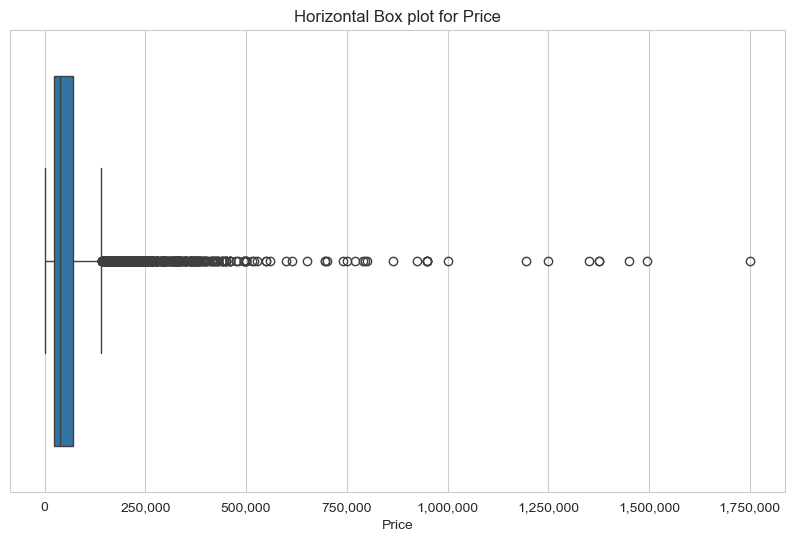

In [35]:
# Removing Outliers by boxplotting each variable

# Create a horizontal box plot for the 'price' attribute
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='price')
plt.title("Horizontal Box plot for Price")
plt.xlabel("Price")

# Define a function to format tick labels, this ensure the full price is 
# shown on the x-axis
def format_tick(x, _):
    return f'{x:,.0f}'

# Update x-axis tick format to display full price
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_tick))

# Show the plot
plt.show()

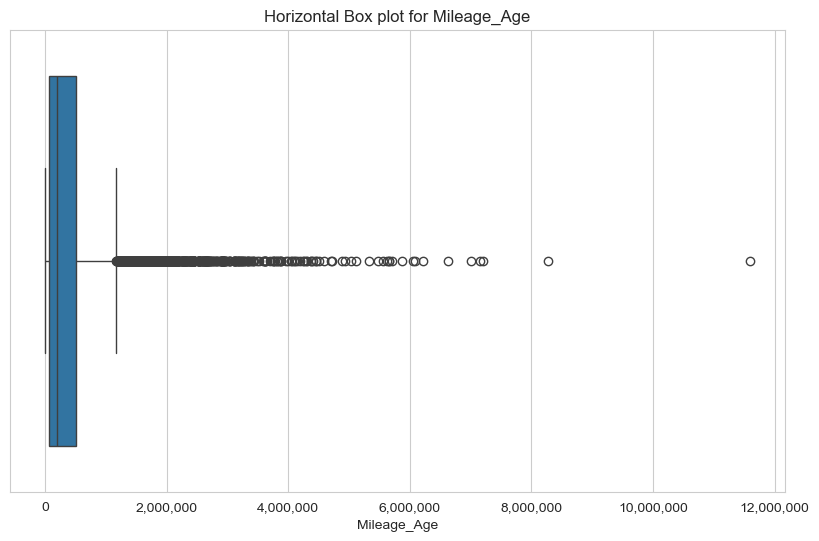

In [36]:
# Create a horizontal box plot for the 'Mileage_Age' attribute
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Mileage_Age')

# Set plot title and x-axis label
plt.title("Horizontal Box plot for Mileage_Age")
plt.xlabel("Mileage_Age")

# Define a function to format tick labels
def format_tick(x, _):
    return f'{x:,.0f}'

# Update x-axis tick format to display full Mileage_Age
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_tick))

# Show the plot
plt.show()

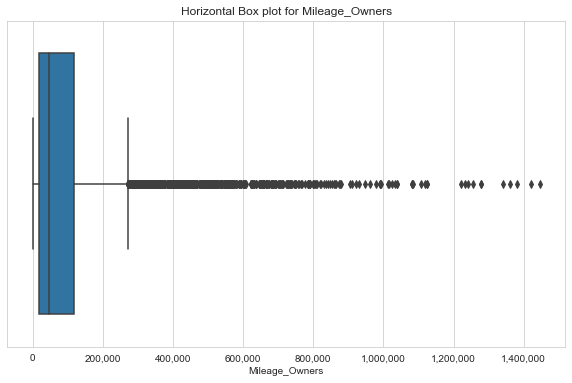

In [643]:
# Create a horizontal box plot for the 'Mileage_Age' attribute
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Mileage_Owners')

# Set plot title and x-axis label
plt.title("Horizontal Box plot for Mileage_Owners")
plt.xlabel("Mileage_Owners")

# Define a function to format tick labels
def format_tick(x, _):
    return f'{x:,.0f}'

# Update x-axis tick format to display full Mileage_Age
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_tick))

# Show the plot
plt.show()

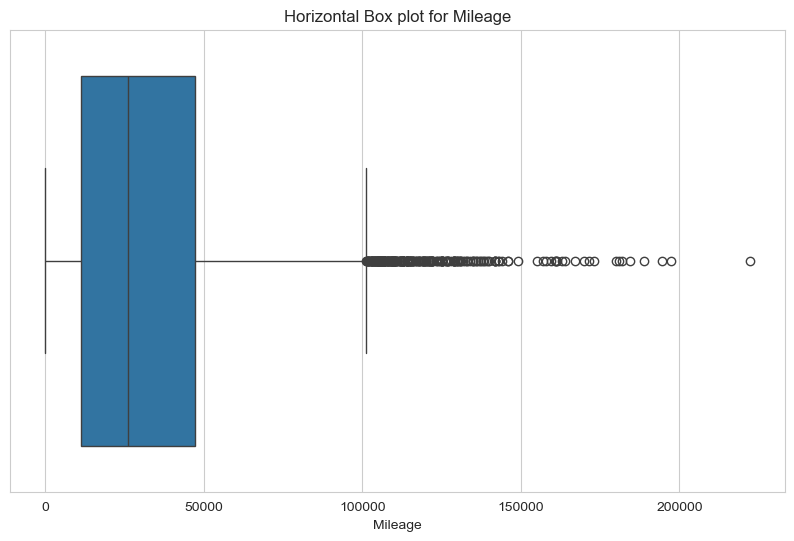

In [37]:
# Create a horizontal box plot for the 'Mileage' attribute
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Mileage')

# Set plot title and x-axis label
plt.title("Horizontal Box plot for Mileage")
plt.xlabel("Mileage")

# Show the plot
plt.show()

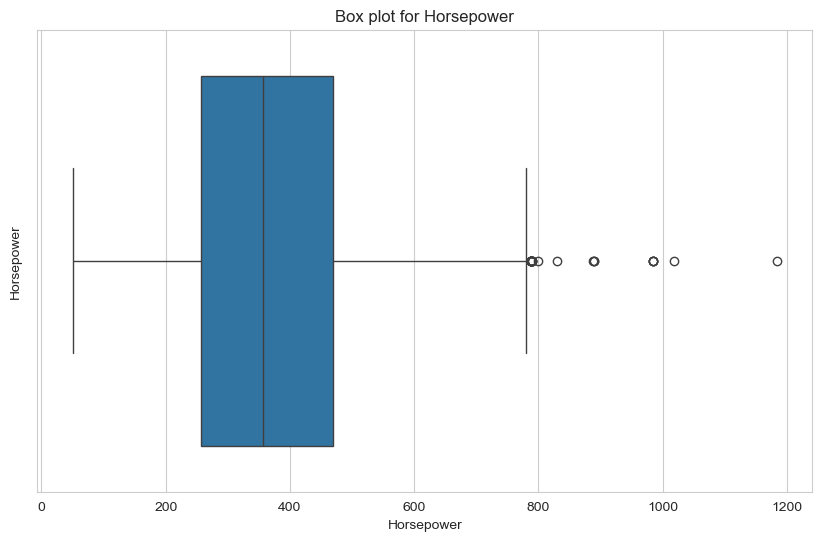

In [38]:
# Create a box plot for the horsepower
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Horsepower')

# Set plot title and y-axis label
plt.title("Box plot for Horsepower")
plt.ylabel("Horsepower")

# Show the plot
plt.show()

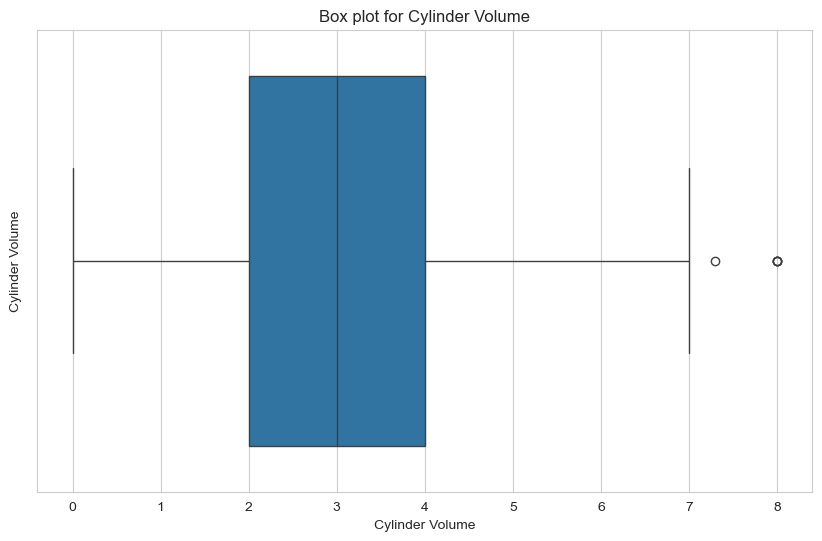

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Cylinder Volume')

# Set plot title and y-axis label
plt.title("Box plot for Cylinder Volume")
plt.ylabel("Cylinder Volume")

# Show the plot
plt.show()

In [40]:
# Removing the outliers
df = df[(df['price'] <= 700000) & 
        (df['Mileage'] <= 150000) & 
        (df['Horsepower'] <= 800)]

### Correlation heatmap to visualise attributes against the target variables. This gives an excellent insight on whether features must be kept or removed. 

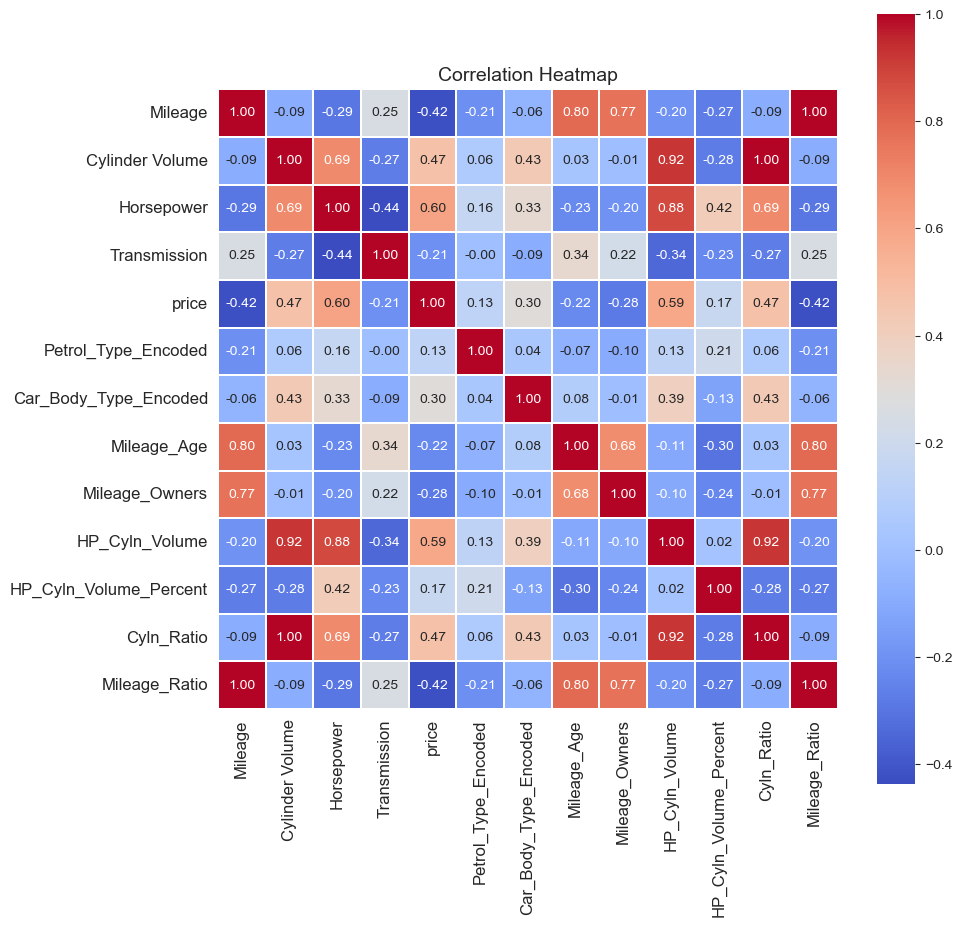

[1.0, 0.6035784134482345, 0.5886603545789572, 0.47449779064192427, 0.47449779064192427, 0.29553591462839135, 0.17198203767523612, 0.1336956073784818, -0.20588004316889663, -0.22445446428954136, -0.2838856666451039, -0.4236575092170271, -0.4236625239739022]


In [41]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Set up the figure size
plt.figure(figsize=(10, 10))

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.1, square=True)

# Set up the plot title and labels
plt.title('Correlation Heatmap', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

# Assuming your data is in a DataFrame called df
correlation_matrix = df.corr()

# Select the correlations with the target variable 'price'
price_correlations = correlation_matrix['price']

# Sort the correlations in descending order
sorted_correlations = price_correlations.sort_values(ascending=False)

# Print the sorted correlations as a list
print(sorted_correlations.to_list())

# Model Implementation

In [42]:
# Separate input features and target variable
X = df.drop('price', axis=1)
y = df['price']

# Splitting the data, 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
# Create the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',  # Leverage RTX 3060
    max_depth=7,             # From your best_params
    learning_rate=0.05,      # Balanced value
    n_estimators=1200,       # Increased from search's 467
    subsample=0.75,          # From best_params
    colsample_bytree=0.6,    # From best_params (not 0.2!)
    gamma=0.7,               # From best_params
    reg_alpha=1.5,           # From best_params
    reg_lambda=3.0,          # From best_params
    min_child_weight=3,      # Added for robustness
    random_state=42
)

# Set up the K-Fold cross-validation
kfold = KFold(n_splits=10, 
              random_state=42, shuffle=True)

# Perform cross-validation and calculate the mean absolute error (MAE)
mae_scores = -1 * cross_val_score(xgb_regressor, X, y, cv=kfold, scoring='neg_mean_absolute_error')

# Print the mean and standard deviation of the MAE scores
print("Mean MAE:", np.mean(mae_scores))
print("Standard Deviation of MAE:", np.std(mae_scores))

# Print the MAE scores for each fold
for i, mae in enumerate(mae_scores, start=1):
    print(f"MAE for fold {i}: {mae}")
   
# Calculate cross-validated R2 scores
r2_scores = cross_val_score(xgb_regressor, X, y, cv=kfold, scoring='r2')

# Print the mean and standard deviation of the R2 scores
print("Mean R2 Score:", np.mean(r2_scores))
print("Standard Deviation of R2 Score:", np.std(r2_scores))

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "D:\anaconda\envs\xgbmodel\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda\envs\xgbmodel\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "D:\anaconda\envs\xgbmodel\lib\site-packages\xgboost\sklearn.py", line 1108, in fit
    self._Booster = train(
  File "D:\anaconda\envs\xgbmodel\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "D:\anaconda\envs\xgbmodel\lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "D:\anaconda\envs\xgbmodel\lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "D:\anaconda\envs\xgbmodel\lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [22:40:53] C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\common\common.h:174: XGBoost version not compiled with GPU support.


In [54]:
# Print the R2 scores for each fold
for i, r2 in enumerate(r2_scores, start=1):
    print(f"R2 Score for fold {i}: {r2}")

R2 Score for fold 1: 0.8554740329315944
R2 Score for fold 2: 0.8066042641812887
R2 Score for fold 3: 0.8615131972536735
R2 Score for fold 4: 0.8382181902008938
R2 Score for fold 5: 0.7988951769768875
R2 Score for fold 6: 0.8355843957412656
R2 Score for fold 7: 0.7982081782693644
R2 Score for fold 8: 0.8374023892300294
R2 Score for fold 9: 0.7359742933426195
R2 Score for fold 10: 0.8792964050211513
R2 Score for fold 11: 0.812096833440783
R2 Score for fold 12: 0.8521359611814789
R2 Score for fold 13: 0.7876629621031062
R2 Score for fold 14: 0.7853914734940669
R2 Score for fold 15: 0.8552803424971092


In [55]:
# Fit the model on training set
xgb_regressor.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = xgb_regressor.predict(X_train)
y_test_pred = xgb_regressor.predict(X_test)

# Calculate R2 score for training and testing sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the R2 scores
print("R2 score for training set:", r2_train)
print("R2 score for testing set:", r2_test)

R2 score for training set: 0.9981133893408357
R2 score for testing set: 0.8213934440477221


In [58]:
# Define hyperparameter search space
param_dist = {
    'learning_rate': uniform(0.01, 0.1),  # Narrower range
    'max_depth': [5, 6, 7, 8, 9],        # Focus around 7
    'n_estimators': randint(800, 2000),   # Higher than before
    'subsample': uniform(0.6, 0.9),
    'colsample_bytree': uniform(0.5, 0.8),
    'gamma': uniform(0.5, 1.0),
    'reg_alpha': uniform(1.0, 4.0),       # Around 1.5
    'reg_lambda': uniform(2.0, 5.0),      # Around 3.0
}

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(xgb_regressor, param_distributions=param_dist,n_iter=100, scoring='neg_mean_absolute_error', cv=kfold, verbose=1, random_state=42)
random_search.fit(X, y)

# Print the best hyperparameters
print("Best hyperparameters:", random_search.best_params_)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Best hyperparameters: {'colsample_bytree': 0.8401246995929958, 'gamma': 0.7079416628681888, 'learning_rate': 0.06677003278199915, 'max_depth': 9, 'n_estimators': 1502, 'reg_alpha': 4.3691390983799945, 'reg_lambda': 4.248770666848828, 'subsample': 0.955635212401633}


In [57]:
# Train the XGBoost model with the best hyperparameters
best_params = random_search.best_params_
xgb_regressor_best = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
xgb_regressor_best.fit(X_train, y_train)

joblib.dump(xgb_regressor_best, 'xgb_model.joblib')

y_train_pred = xgb_regressor_best.predict(X_train)
rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
print("RMSE for the training set:", rmse_train)

# Calculate the RMSE for the testing set
y_test_pred = xgb_regressor_best.predict(X_test)
rmse_test = sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE for the testing set:", rmse_test)

RMSE for the training set: 9185.592041015138
RMSE for the testing set: 26927.650856886772


In [56]:
# Make predictions on the test dataset
y_pred = xgb_regressor_best.predict(X_test)
# Calculate the mean absolute error, mean squared error, and R-squared score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Mean Absolute Error: 11699.855568683812
Mean Squared Error: 725098380.6703949
R-squared Score: 0.824524719966875


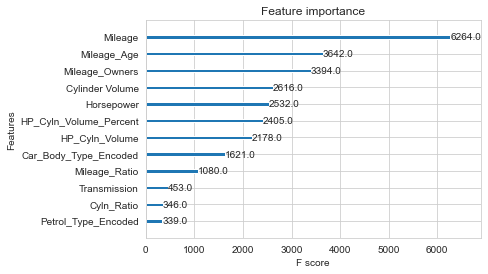

Horsepower: 0.2785916328430176
Cyln_Ratio: 0.23453590273857117
Petrol_Type_Encoded: 0.0709531381726265
Mileage_Ratio: 0.06970738619565964
Mileage: 0.0648207813501358
HP_Cyln_Volume: 0.05786712467670441
Cylinder Volume: 0.05607260763645172
Mileage_Age: 0.04683821275830269
HP_Cyln_Volume_Percent: 0.03659536689519882
Transmission: 0.03195659816265106
Car_Body_Type_Encoded: 0.031046543270349503
Mileage_Owners: 0.021014709025621414


In [674]:
# Plot the feature importance
xgb.plot_importance(xgb_regressor_best)
plt.show()

# Get the feature importance from the model
importance_scores = xgb_regressor_best.feature_importances_

# Map the scores to the corresponding feature names
feature_importances = {column: importance for column, importance in zip(X_train.columns, importance_scores)}

# Sort the features by importance
sorted_feature_importances = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)

# Print the sorted feature importances
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

In [666]:
# Save the trained XGBoost model
with open('xgboost_car_price_predictor.pkl', 'wb') as file:
    pickle.dump(xgb_regressor_best, file)

# Load the saved XGBoost model
with open('xgboost_car_price_predictor.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [676]:
# Define a function to encode the categorical features
def encode_categorical_features(transmission, petrol_type, car_body_type, label_encoder, mean_encoding, mean_encoding_body_type):
    transmission_encoded = label_encoder.transform([transmission])[0]
    petrol_type_encoded = mean_encoding[petrol_type]
    car_body_type_encoded = mean_encoding_body_type[car_body_type]

    return transmission_encoded, petrol_type_encoded, car_body_type_encoded

# Prompt the user for input
year = int(input("Enter the year of the car: "))
car_body_type = input("Enter the car body type: ")
mileage = int(input("Enter the mileage of the car: "))
cylinder_volume = float(input("Enter the cylinder volume of the car: "))
horsepower = int(input("Enter the horsepower of the car: "))
transmission = input("Enter the transmission type (Manual, Auto, Other): ")
petrol_type = input("Enter the petrol type: ")
owners = int(input("Enter the number of owners: "))

# Encode the categorical variables
transmission_encoded, petrol_type_encoded, car_body_type_encoded = encode_categorical_features(transmission, petrol_type, car_body_type, label_encoder, mean_encoding, mean_encoding_body_type)

# Calculate the age of the car
current_year = datetime.datetime.now().year
age = current_year - year


# Calculate the new features
mileage_age = mileage * age
mileage_owners = mileage * owners
hp_cyln_volume = horsepower * cylinder_volume
HP_Cyln_Volume_Percent = horsepower 
cyln_volume_car_body_type = cylinder_volume * car_body_type_encoded

# Create an array with the input features
input_features = np.array([mileage, cylinder_volume, horsepower, transmission_encoded, petrol_type_encoded, car_body_type_encoded, age, mileage_age, mileage_owners, hp_cyln_volume, cyln_volume_car_body_type, horsepower_transmission])

# Reshape the input features array
input_features = input_features.reshape(1, -1)

# Make a prediction using the loaded XGBoost model
predicted_price = xgb_regressor_best.predict(input_features)

# Print the predicted price
print(f"The predicted price of the car is: £{predicted_price[0]:,.2f}")

Enter the year of the car: 2022
Enter the car body type: Coupe
Enter the mileage of the car: 20000
Enter the cylinder volume of the car: 2.0
Enter the horsepower of the car: 233
Enter the transmission type (Manual, Auto, Other): Auto
Enter the petrol type: Petrol
Enter the number of owners: 3
The predicted price of the car is: £197,150.80
